# Assignment 3
## Image Captioning with RNNs

In [1]:
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.rnn_layers import *
from cs231n.captioning_solver import CaptioningSolver
from cs231n.classifiers.rnn import CaptioningRNN
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

## Microsoft COCO

COCO 数据集有 80k 张训练数据，40k 张验证数据，每一个图片都有 5 个标注

cs231n 课程老师已经对数据进行过预处理，提取出后面作业中所需的特征。对于所有图像，从 VGG-16 的 fc7 层提取出特征，存储在文件 train2014_vgg16_fc7.h5 和 val2014_vgg16_fc7.h5 中。为减少处理时间和内存需求，特征的维数从 4096 降到了 512，这些特征在文件 train2014_vgg16_fc7_pca.h5 和 val2014_vgg16_fc7_pca.h5

原始图像占用大量空间，因此没有将其包含在下载中。所有图片均取自 Flickr，训练和验证图像的 URL 分别存储在文件 train2014_url.txt 和 val2014_url.txt 中。因此，可以动态下载数据

处理字符串的效率很低，所以将标注进行编码。每个单词都分配了一个整数 ID，于是我们可以使用一系列的整数来表示每个标注。整数 ID 和单词之间的映射表存在文件 coco2014_vocab.json 中可以找到，我们可以使用 coco_utils.py 中的 decode_caption 函数将整数 ID 转换成对应的字符串

单词表中添加了一些特殊的标记，我们在每个标注的开头和结尾分别添加了一个特殊的标记 <START\> 和 <END\> ,一些不常见的单词我们用 <UNK\> 进行标记。此外，由于 minibatch 会包含不同长度的标注，我们在 <END\> 标记后为较短标注的添加了 <NULL\> 标记，对于 <NULL\> 标记我们不计算损失和梯度

在 coco_utils.py 中提供了 load_coco_data 函数加载所有的 MS-COCO 数据（标注、特征、 URL、单词表）

In [2]:
# 加载 COCO 数据集，返回一个字典集合
data = load_coco_data(pca_features = True)

for k, v, in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


## Look at the data

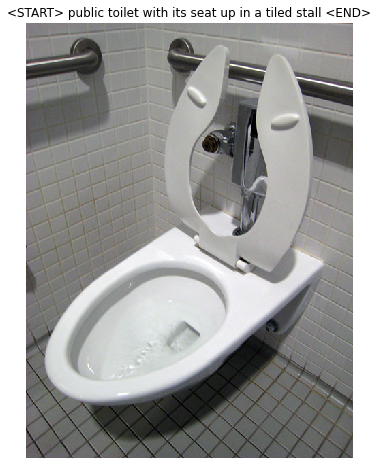

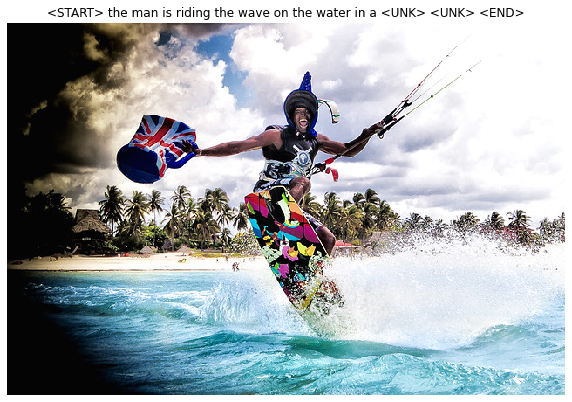

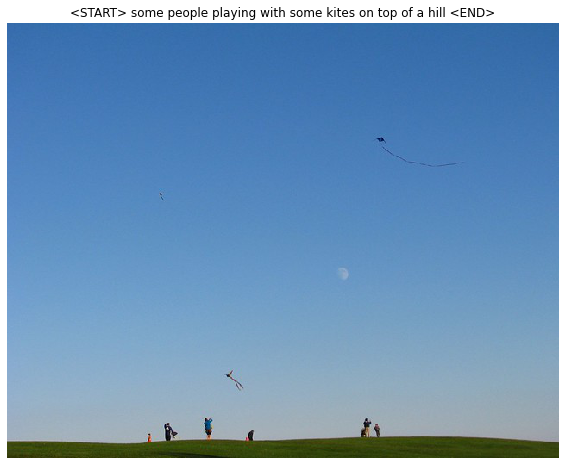

In [3]:
# 采样 minibatch 查看一下数据集图片和标注

batch_size = 3
captions, features, urls = sample_coco_minibatch(data, batch_size = batch_size)
for i, (caption, url) in enumerate(zip(captions, urls)):
    plt.imshow(image_from_url(url))
    plt.axis('off')
    caption_str = decode_captions(caption, data['idx_to_word'])
    plt.title(caption_str)
    plt.show()

## Recurrent Neural Networks
## Vanilla RNN: step forward

In [4]:
# 测试一下 rnn_step_forward 
N, D, H = 3, 10, 4

x = np.linspace(-0.4, 0.7, num= N * D).reshape(N, D)
prev_h = np.linspace(-0.2, 0.5, num = N * H).reshape(N, H)
Wx = np.linspace(-0.1, 0.9, num = D * H).reshape(D, H)
Wh = np.linspace(-0.3, 0.7, num = H * H).reshape(H, H)
b = np.linspace(-0.2, 0.4, num = H)

next_h, _ = rnn_step_forward(x, prev_h, Wx, Wh, b)
expected_next_h = np.asarray([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]])

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  6.292421426471037e-09


## Vanilla RNN: step backward

In [5]:
# 测试一下 rnn_step_backward 
from cs231n.rnn_layers import rnn_step_forward, rnn_step_backward

N, D, H = 4, 5, 6
x = np.random.randn(N, D)
h = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_step_forward(x, h, Wx, Wh, b)

dnext_h = np.random.randn(*out.shape)

fx = lambda x: rnn_step_forward(x, h, Wx, Wh, b)[0]
fh = lambda prev_h: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_step_forward(x, h, Wx, Wh, b)[0]
fb = lambda b: rnn_step_forward(x, h, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dnext_h)
dprev_h_num = eval_numerical_gradient_array(fh, h, dnext_h)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dnext_h)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dnext_h)
db_num = eval_numerical_gradient_array(fb, b, dnext_h)

dx, dprev_h, dWx, dWh, db = rnn_step_backward(dnext_h, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dprev_h error: ', rel_error(dprev_h_num, dprev_h))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  2.868217797192726e-10
dprev_h error:  6.10907859723129e-11
dWx error:  2.174417096418575e-10
dWh error:  7.870766848517926e-10
db error:  1.4305504646470866e-11


## Vanilla RNN: forward

In [6]:
# 测试一下 rnn_forward 
N, T, D, H = 2, 3, 4, 5

x = np.linspace(-0.1, 0.3, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.3, 0.1, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.4, num=D*H).reshape(D, H)
Wh = np.linspace(-0.4, 0.1, num=H*H).reshape(H, H)
b = np.linspace(-0.7, 0.1, num=H)

h, _ = rnn_forward(x, h0, Wx, Wh, b)
expected_h = np.asarray([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]])
print('h error: ', rel_error(expected_h, h))

h error:  7.728466151011529e-08


## Vanilla RNN: backward

In [7]:
N, D, T, H = 2, 3, 10, 5

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

fx = lambda x: rnn_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: rnn_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: rnn_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  6.468730997993164e-10
dh0 error:  4.370117123211951e-09
dWx error:  6.447191269787193e-09
dWh error:  9.336141923841493e-10
db error:  7.429484659277487e-10


## Word embedding: forward

In [8]:
# 测试一下 word_embedding_forward
N, T, V, D = 2, 4, 5, 3

x = np.asarray([[0, 3, 1, 2], [2, 1, 0, 3]])
W = np.linspace(0, 1, num=V*D).reshape(V, D)

out, _ = word_embedding_forward(x, W)
expected_out = np.asarray([
 [[ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.42857143,  0.5,         0.57142857]],
 [[ 0.42857143,  0.5,         0.57142857],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429]]])

print('out error: ', rel_error(expected_out, out))

out error:  1.0000000094736443e-08


## Word embedding: backward

In [9]:
# 测试一下 word_embedding_backward
N, T, V, D = 50, 3, 5, 6

x = np.random.randint(V, size=(N, T))
W = np.random.randn(V, D)

out, cache = word_embedding_forward(x, W)
dout = np.random.randn(*out.shape)
dW = word_embedding_backward(dout, cache)

f = lambda W: word_embedding_forward(x, W)[0]
dW_num = eval_numerical_gradient_array(f, W, dout)

print('dW error: ', rel_error(dW, dW_num))

dW error:  3.275799402026574e-12


## Temporal Affine Layer

在每个时间步上，我们使用全连接函数将 RNN 在当前时间步上的隐藏向量转化为单词表中每个单词的得分

In [10]:
# 测试一下 temporal_affine_forward 和 temporal_affine_backward
N, T, D, M = 2, 3, 4, 5

x = np.random.randn(N, T, D)
w = np.random.randn(D, M)
b = np.random.randn(M)

out, cache = temporal_affine_forward(x, w, b)

dout = np.random.randn(*out.shape)

fx = lambda x: temporal_affine_forward(x, w, b)[0]
fw = lambda w: temporal_affine_forward(x, w, b)[0]
fb = lambda b: temporal_affine_forward(x, w, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dw_num = eval_numerical_gradient_array(fw, w, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

dx, dw, db = temporal_affine_backward(dout, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

dx error:  1.9877262793797427e-10
dw error:  2.422083262282679e-10
db error:  3.2757002124186172e-12


## Temporal Softmax Loss

RNN 中，在每个时间步我们会对每个单词产生一个分数。在每个时间中，ground-truth word 是已知的，于是我们就可以根据 softmax loss 计算每个时间步上的损失和梯度。我们将所有时间步上的损失求和，然后对 minibatch 求平均

In [11]:
# 测试一下 temporal_softmax_loss
from cs231n.rnn_layers import temporal_softmax_loss

N, T, V = 100, 1, 10

def check_loss(N, T, V, p):
  x = 0.001 * np.random.randn(N, T, V)
  y = np.random.randint(V, size=(N, T))
  mask = np.random.rand(N, T) <= p
  print(temporal_softmax_loss(x, y, mask)[0])
  
check_loss(100, 1, 10, 1.0)   # Should be about 2.3
check_loss(100, 10, 10, 1.0)  # Should be about 23
check_loss(5000, 10, 10, 0.1) # Should be about 2.3

# Gradient check for temporal softmax loss
N, T, V = 7, 8, 9

x = np.random.randn(N, T, V)
y = np.random.randint(V, size=(N, T))
mask = (np.random.rand(N, T) > 0.5)

loss, dx = temporal_softmax_loss(x, y, mask, verbose=False)

dx_num = eval_numerical_gradient(lambda x: temporal_softmax_loss(x, y, mask)[0], x, verbose=False)

print('dx error: ', rel_error(dx, dx_num))

2.3025151825199863
23.02594801996011
2.2988858121312425
dx error:  6.425912816274803e-08


## RNN for image captioning

In [12]:
# 既然前面所有函数验证正确，我们就可以把它们和组合成 RNN 模型
# 可以用个小点的数据集验证一下 RNN 模型
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
                      input_dim=D,
                      wordvec_dim=W,
                      hidden_dim=H,
                      cell_type='rnn',
                      dtype=np.float64)

# 将模型的所有参数设定成固定值
for k, v in model.params.items():
  model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-1.5, 0.3, num=(N * D)).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.83235591003

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

loss:  9.832355910027388
expected loss:  9.83235591003
difference:  2.611244553918368e-12


In [13]:
# 对 CaptioningRNN 进行梯度检查
batch_size = 2
timesteps = 3
input_dim = 4
wordvec_dim = 5
hidden_dim = 6
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
vocab_size = len(word_to_idx)

captions = np.random.randint(vocab_size, size=(batch_size, timesteps))
features = np.random.randn(batch_size, input_dim)

model = CaptioningRNN(word_to_idx,
                      input_dim=input_dim,
                      wordvec_dim=wordvec_dim,
                      hidden_dim=hidden_dim,
                      cell_type='rnn',
                      dtype=np.float64,)

loss, grads = model.loss(features, captions)

for param_name in sorted(grads):
    f = lambda _: model.loss(features, captions)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s relative error: %e' % (param_name, e))

W_embed relative error: 1.434300e-09
W_proj relative error: 3.672931e-08
W_vocab relative error: 3.270608e-09
Wh relative error: 9.473375e-09
Wx relative error: 2.787105e-07
b relative error: 3.377477e-10
b_proj relative error: 1.693447e-09
b_vocab relative error: 2.255539e-10


## Overfit small data

下面我们让模型去过拟合一个 100 大小的数据集，损失应该接近于 1 

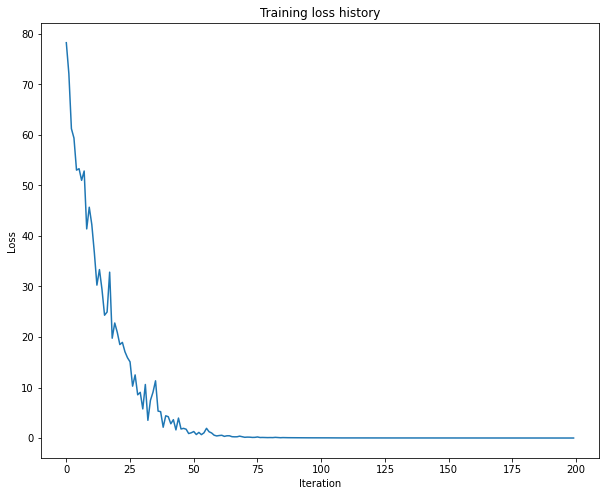

In [14]:
small_data = load_coco_data(max_train=100)

small_rnn_model = CaptioningRNN(cell_type = 'rnn',
                                word_to_idx = data['word_to_idx'],
                                input_dim = data['train_features'].shape[1],
                                hidden_dim = 512,
                                wordvec_dim = 256,)

small_rnn_solver = CaptioningSolver(small_rnn_model,                                    
                                    small_data,
                                    update_rule = 'adam',
                                    num_epochs = 50,
                                    batch_size = 25,
                                    optim_config = {'learning_rate': 5e-3,},
                                    lr_decay = 0.95,
                                    verbose = True, 
                                    print_every=10,)

small_rnn_solver.train()

plt.plot(small_rnn_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

## Test-time sampling 

与分类模型不同的是，图片标注模型在训练时和测试时的行为是十分不同的。训练时，我们需要获取 ground-truth caption，这样我们就可以在每个时间步中把 ground-truth words 喂入模型。在测试时，我们每个时间步对单词表的分布信息进行采样，然后将采样结果喂入 RNN 的下一个时间步

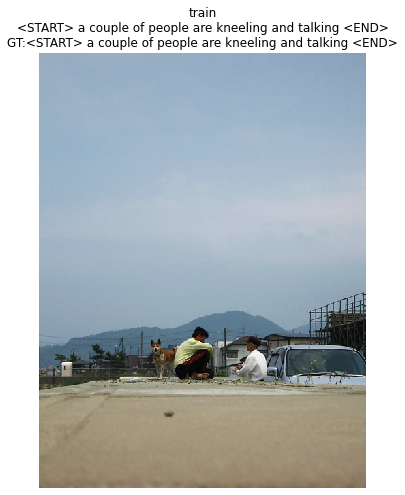

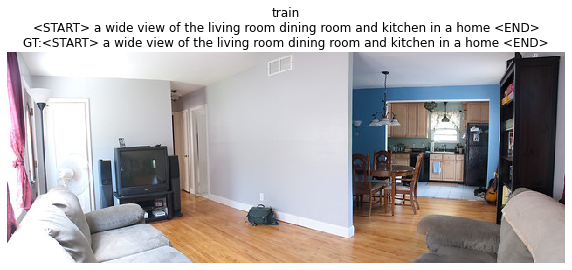

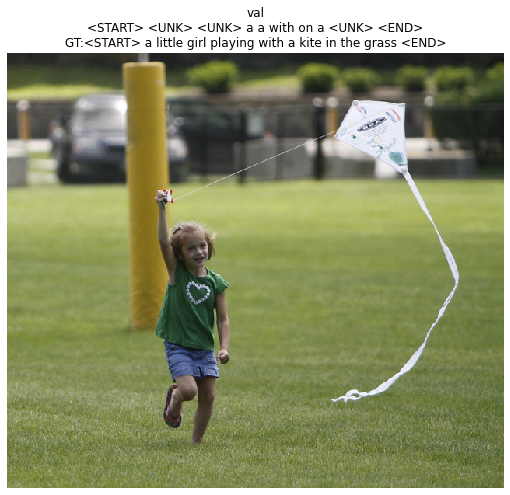

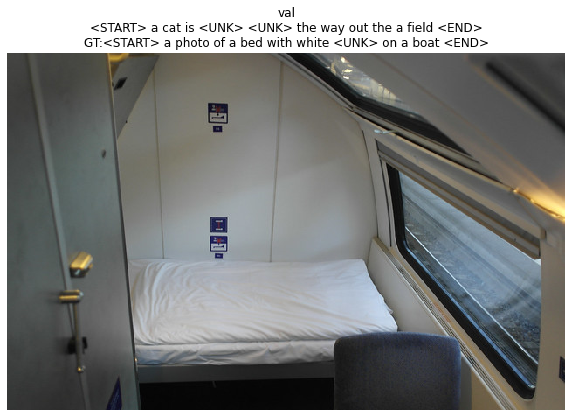

In [15]:
# 从刚才过拟合的模型中对训练数据和验证数据采样
# 训练数据的采样应该表现十分不错
# 但是在验证数据上的采样就没有什么实际意义了

for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_rnn_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()